# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [ ]:
!tar cvfz allfiles.tar.gz *
!split -b 50m allfiles.tar.gz allfiles.tar.gz.part

CODEOWNERS
Deep Lab.png
Golden-Gate-Bridge-San-Francisco.jpg
LICENSE.txt
README.md
__pycache__/
__pycache__/extract_bottleneck_features.cpython-36.pyc
bottleneck_features/
bottleneck_features/DogVGG16Data.npz


In [1]:
import os
import cv2   
import keras
import random
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt   
from extract_bottleneck_features import *
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.utils import np_utils
from keras.preprocessing import image                  
from keras.callbacks import ModelCheckpoint  
from keras.models import Sequential, Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Check the distribution of images in the training dataset

In [4]:
# get the image count for each breed in the training data 
index, counts = np.unique(np.argmax(train_targets, axis = -1), return_counts = True)
print(f'Average number of images per breed: {np.round(np.mean(counts), 2)}')

# breeds with minimum number of images
ids = np.where(np.min(counts) == counts)[0].tolist()

print(f'Dog breeds with minimum number of images in the training set:')
for i in ids:
    print(f"Dog breed: {dog_names[i].split('.')[-1]}\tNumber of images: {np.min(counts)}")
        
# breeds with maximum number of images
ids = np.where(np.max(counts) == counts)[0].tolist()

print(f'Dog breeds with maximum number of images in the training set:')
for i in ids:
    print(f"Dog breed: {dog_names[i].split('.')[-1]}\tNumber of images: {np.max(counts)}")

Average number of images per breed: 50.23
Dog breeds with minimum number of images in the training set:
Dog breed: Norwegian_buhund	Number of images: 26
Dog breed: Xoloitzcuintli	Number of images: 26
Dog breeds with maximum number of images in the training set:
Dog breed: Alaskan_malamute	Number of images: 77


In [5]:
# print the number of images per dog breed
for ids, count in zip(index, counts):
    print(f"Dog breed: {dog_names[ids].split('.')[-1]}\t\t\tNumber of images: {count}")

Dog breed: Affenpinscher			Number of images: 64
Dog breed: Afghan_hound			Number of images: 58
Dog breed: Airedale_terrier			Number of images: 52
Dog breed: Akita			Number of images: 63
Dog breed: Alaskan_malamute			Number of images: 77
Dog breed: American_eskimo_dog			Number of images: 64
Dog breed: American_foxhound			Number of images: 50
Dog breed: American_staffordshire_terrier			Number of images: 66
Dog breed: American_water_spaniel			Number of images: 34
Dog breed: Anatolian_shepherd_dog			Number of images: 50
Dog breed: Australian_cattle_dog			Number of images: 66
Dog breed: Australian_shepherd			Number of images: 66
Dog breed: Australian_terrier			Number of images: 46
Dog breed: Basenji			Number of images: 69
Dog breed: Basset_hound			Number of images: 73
Dog breed: Beagle			Number of images: 59
Dog breed: Bearded_collie			Number of images: 62
Dog breed: Beauceron			Number of images: 50
Dog breed: Bedlington_terrier			Number of images: 48
Dog breed: Belgian_malinois			Number of

### Plot the distribution of images in the training dataset

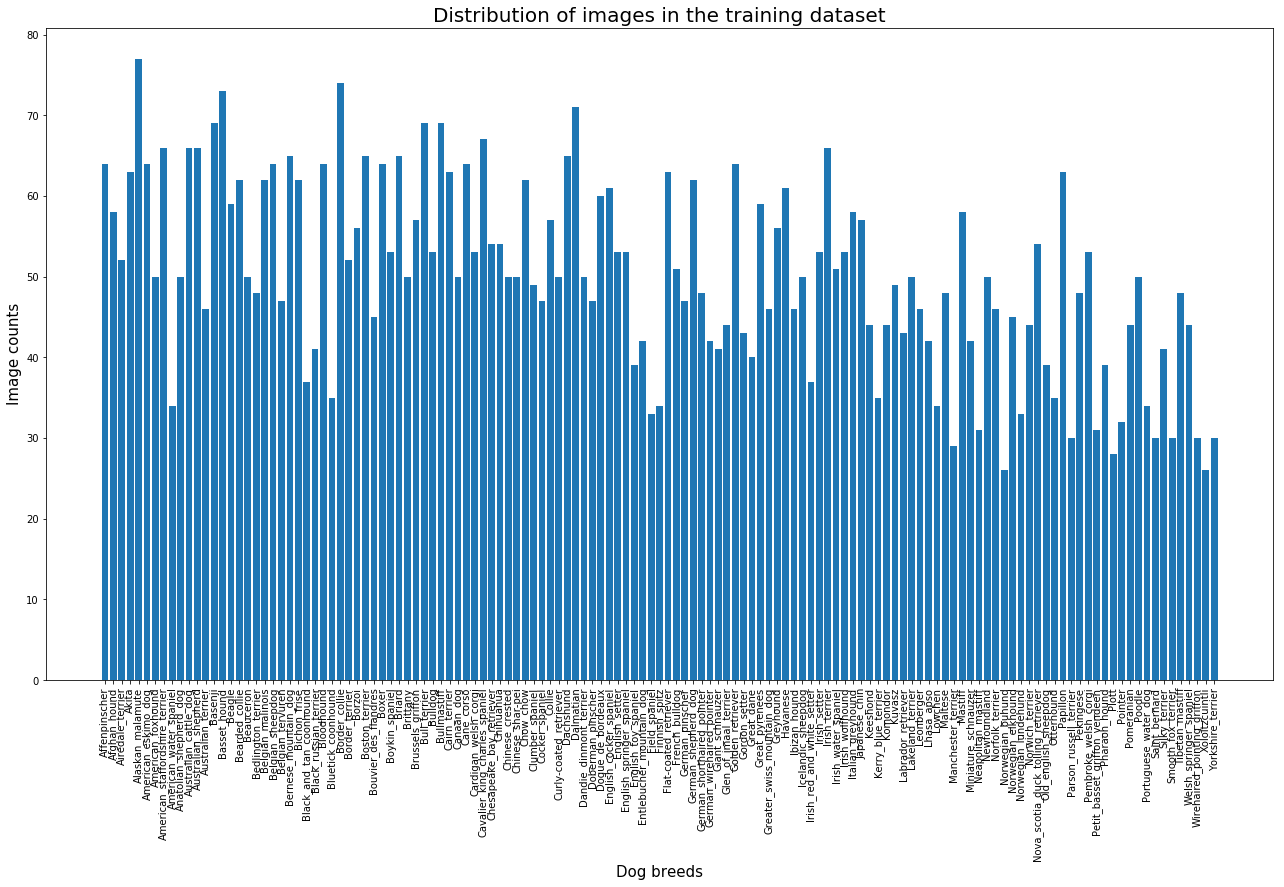

In [6]:
plt.figure(figsize = (22, 12))

labels = []
for ids in index:
    labels.append(dog_names[ids].split('.')[-1])
    
plt.bar(labels, counts)
plt.xticks(rotation = 90)

plt.xlabel('Dog breeds', fontsize = 15)
plt.ylabel('Image counts', fontsize = 15)
plt.title('Distribution of images in the training dataset', fontsize = 20);

- As can be seen from the above graph, the **number of images are not equal in each class** in the training dataset. There are few **classes that have about 30 images** and there are few **classes that have more than 60 images**.
- **Training data is not balanced**.

### Check the distribution of images in the validation dataset

In [7]:
# get the image count for each breed in the validation data 
index, counts = np.unique(np.argmax(valid_targets, axis = -1), return_counts = True)
print(f'Average number of images per breed: {np.round(np.mean(count), 2)}\n')

# breeds with minimum number of images
ids = np.where(np.min(counts) == counts)[0].tolist()

print(f'Dog breeds with minimum number of images in the validation set:')
for i in ids:
    print(f"Dog breed: {dog_names[i].split('.')[-1]}\tNumber of images: {np.min(counts)}")
print('\n')
          
# breeds with maximum number of images
ids = np.where(np.max(counts) == counts)[0].tolist()

print(f'Dog breeds with maximum number of images in the validation set:')
for i in ids:
    print(f"Dog breed: {dog_names[i].split('.')[-1]}\tNumber of images: {np.max(counts)}")

Average number of images per breed: 30.0

Dog breeds with minimum number of images in the validation set:
Dog breed: American_water_spaniel	Number of images: 4
Dog breed: Field_spaniel	Number of images: 4
Dog breed: Finnish_spitz	Number of images: 4
Dog breed: Lowchen	Number of images: 4
Dog breed: Manchester_terrier	Number of images: 4
Dog breed: Neapolitan_mastiff	Number of images: 4
Dog breed: Norwegian_buhund	Number of images: 4
Dog breed: Norwegian_lundehund	Number of images: 4
Dog breed: Parson_russell_terrier	Number of images: 4
Dog breed: Petit_basset_griffon_vendeen	Number of images: 4
Dog breed: Plott	Number of images: 4
Dog breed: Pointer	Number of images: 4
Dog breed: Portuguese_water_dog	Number of images: 4
Dog breed: Saint_bernard	Number of images: 4
Dog breed: Smooth_fox_terrier	Number of images: 4
Dog breed: Wirehaired_pointing_griffon	Number of images: 4
Dog breed: Xoloitzcuintli	Number of images: 4
Dog breed: Yorkshire_terrier	Number of images: 4


Dog breeds with max

### Plot the distribution of images in the validation dataset

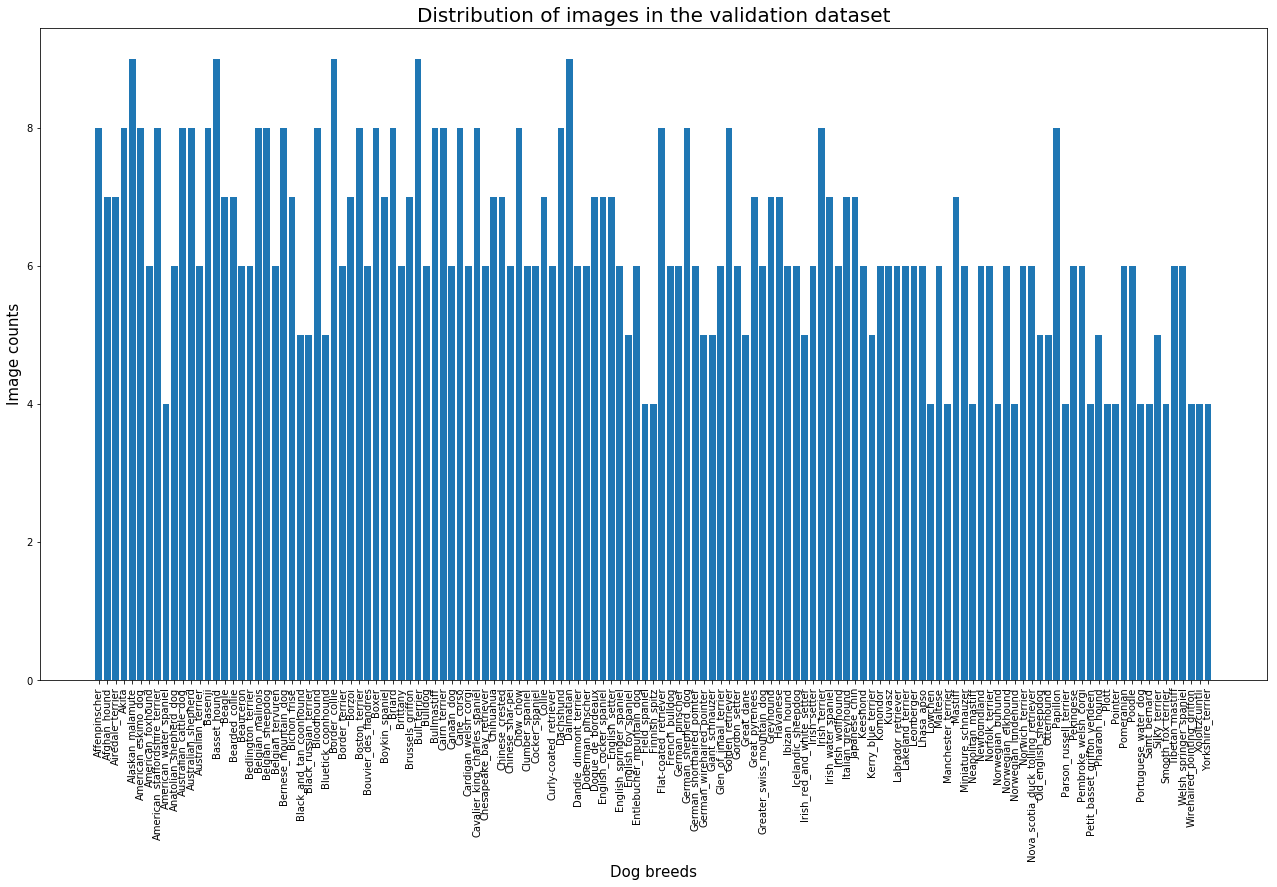

In [8]:
plt.figure(figsize = (22, 12))

labels = []
for ids in index:
    labels.append(dog_names[ids].split('.')[-1])
    
plt.bar(labels, counts)
plt.xticks(rotation = 90)

plt.xlabel('Dog breeds', fontsize = 15)
plt.ylabel('Image counts', fontsize = 15)
plt.title('Distribution of images in the validation dataset', fontsize = 20);

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [9]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


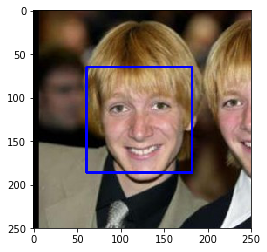

In [10]:
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[172])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x, y), (x + w, y + h), (255, 0, 0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [11]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- Percentage of human faces detected in human images: 100%
- Percentage of human faces detected in dog images: 11%

In [12]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm
count = 0
for file in human_files_short:
    if face_detector(file):
        count += 1
print(f'Percentage of human faces detected in human images: {count}')
## on the images in human_files_short and dog_files_short.
count = 0
for file in dog_files_short:
    if face_detector(file):
        count += 1
print(f'Percentage of human faces detected in dog images: {count}')

Percentage of human faces detected in human images: 100
Percentage of human faces detected in dog images: 11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
- This is not a reasonable expectation to pose on the user. The face detector algorithm should be able to detect faces in wide range of images with distortions. We can detect human faces in images using deep learning models such as MTCNN with greater accuracy than the OpenCV's face detector.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [13]:
# define ResNet50 model
ResNet50_model = keras.applications.ResNet50(weights = 'imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [14]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [15]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- Percentage of dogs detected in `human_files_short` list of images: 0%
- Percentage of dogs detected in `dog_files_short` list of images: 100%

In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
count = 0
for file in human_files_short:
    if dog_detector(file):
        count += 1
print(f'Percentage of dogs detected in human images: {count}')

count = 0
for file in dog_files_short:
    if dog_detector(file):
        count += 1
print(f'Percentage of dogs detected in dog images: {count}')

Percentage of dogs detected in human images: 0
Percentage of dogs detected in dog images: 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 106.05it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
- The details of the CNN model that I used to classify the images is given below

| Layer Name |
|---|
| Conv2D |
| MaxPooling2D |
| Conv2D |
| MaxPooling2D |
| Dropout |
| Conv2D |
| MaxPooling2D |
| Conv2D |
| MaxPooling2D |
| Dropout |
| Conv2D |
| MaxPooling2D |
| GlobalAveragePooling2D |
| Dense |

- Since there are 133 categories to classify dog breeds and the **number of images per breed is small**, we need a deeper CNN model that can extract the important features from the images. But very deep networks trained from scratch on a small dataset tend to overfit the training set and will not generalize well.
- I build a CNN model that is neither too deep nor shallow. It has **five blocks of Conv2D layer followed by MaxPooling2D layer**. I added a **dropout layer** after every two blocks of Conv2D and MaxPooing2D layers to **avoid overfitting**. 
- The two starting blocks of Conv2D and MaxPooling2D layers will extract the **basic features such as horizontal, vertical and diagonal lines, and corners**. The MaxPooling2D layer downsamples the feature maps generated by the Conv2D layers by filtering out the most strong activations. These layers also makes the network **translational equivariance**.
- The deeper blocks of Conv2D layers will combine the basic features to recognize more complex shapes. The **GlobalAveragePooling2D layer is added to reduce the number of parameters** in the network. The final dense layer is the classification layer.

In [19]:
### TODO: Define your architecture.
model = Sequential(name = 'Breed_Classifier')
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', 
                        input_shape = (224, 224, 3), name = 'conv_1'))
model.add(layers.MaxPooling2D(name = 'pool_1'))

model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
                        name = 'conv_2'))
model.add(layers.MaxPooling2D(name = 'pool_2'))
model.add(layers.Dropout(0.3, name = 'drop_1'))

model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
                        name = 'conv_3'))
model.add(layers.MaxPooling2D(name = 'pool_3'))

model.add(layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu',
                        name = 'conv_4'))
model.add(layers.MaxPooling2D(name = 'pool_4'))
model.add(layers.Dropout(0.3, name = 'drop_4'))

model.add(layers.Conv2D(512, (3, 3), padding = 'same', activation = 'relu', 
                        name = 'conv_5'))
model.add(layers.MaxPooling2D(name = 'pool_5'))

model.add(layers.GlobalAveragePooling2D(name = 'gpool'))
model.add(layers.Dense(133, activation = 'softmax', name = 'output'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 64)      18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 56, 56, 64)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 56, 56, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 56, 56, 128)       73856     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 28, 28, 128)       0         
__________

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 6

# compile the model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'rmsprop', 
              metrics = ['accuracy'])

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.from_scratch.hdf5', 
                               verbose = 1, save_best_only = True)

model.fit(train_tensors, train_targets, 
          validation_data = (valid_tensors, valid_targets),
          epochs = epochs, batch_size = 20, callbacks = [checkpointer], verbose = 1)

Train on 6680 samples, validate on 835 samples
Epoch 1/6
6680/6680 [==============================] - 53s 8ms/step - loss: 4.8963 - acc: 0.0118 - val_loss: 4.8543 - val_acc: 0.0144
Epoch 2/6
6680/6680 [==============================] - 52s 8ms/step - loss: 4.8125 - acc: 0.0132 - val_loss: 4.7688 - val_acc: 0.0156
Epoch 3/6
6680/6680 [==============================] - 52s 8ms/step - loss: 4.6920 - acc: 0.0189 - val_loss: 4.6202 - val_acc: 0.0240
Epoch 4/6
6680/6680 [==============================] - 52s 8ms/step - loss: 4.5550 - acc: 0.0338 - val_loss: 4.4565 - val_acc: 0.0443
Epoch 5/6
6680/6680 [==============================] - 52s 8ms/step - loss: 4.3601 - acc: 0.0487 - val_loss: 4.3283 - val_acc: 0.0635
Epoch 6/6
6680/6680 [==============================] - 52s 8ms/step - loss: 4.1737 - acc: 0.0674 - val_loss: 4.2902 - val_acc: 0.0539


### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis = 0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(dog_breed_predictions)== np.argmax(test_targets, axis = 1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.8612%


### Function to plot the loss and accuracy cruves of the model 

In [24]:
def plot_loss_accuracy(history, model_name, epochs = 10):
    """
    This function plots the loss and accuracy of the model on training and validation data
    
    Args:
        history: model training history
        model_name: name of the model (string)
        epochs: number of epochs (default value: 10)
    """
    
    # create figure object
    fig, ax = plt.subplots(1, 2, figsize = (15, 6))
    # plot training and validation loss
    ax[0].plot(range(1, epochs + 1), history.history['loss'])
    ax[0].plot(range(1, epochs + 1), history.history['val_loss'])
    ax[0].set_title(f'Training and validation loss curve of {model_name} model')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'])
    
    # plot training and validation accuracy
    ax[1].plot(range(1, epochs + 1), history.history['acc'])
    ax[1].plot(range(1, epochs + 1), history.history['val_acc'])
    ax[1].set_title(f'Training and validation accuracy curve of {model_name} model')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['train', 'val']);

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [25]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [26]:
VGG16_model = Sequential()
VGG16_model.add(layers.GlobalAveragePooling2D(input_shape = train_VGG16.shape[1:]))
VGG16_model.add(layers.Dense(133, activation = 'softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [27]:
# compile the model
VGG16_model.compile(loss = 'categorical_crossentropy',
                    optimizer = 'rmsprop', 
                    metrics = ['accuracy'])

# create model checkpoints
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.VGG16_model.hdf5', 
                               verbose = 1, save_best_only = True)

# fit the model on training data
vgg16_history = VGG16_model.fit(train_VGG16, train_targets, 
                                epochs = 30, batch_size = 32, 
                                callbacks = [checkpointer],
                                validation_data = (valid_VGG16, valid_targets),
                                verbose = 1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 2s 231us/step - loss: 12.7372 - acc: 0.0942 - val_loss: 11.0774 - val_acc: 0.1760
Epoch 2/30
6680/6680 [==============================] - 1s 179us/step - loss: 10.1411 - acc: 0.2569 - val_loss: 9.7442 - val_acc: 0.2838
Epoch 3/30
6680/6680 [==============================] - 1s 179us/step - loss: 9.3422 - acc: 0.3418 - val_loss: 9.4386 - val_acc: 0.3269
Epoch 4/30
6680/6680 [==============================] - 1s 180us/step - loss: 9.0092 - acc: 0.3850 - val_loss: 9.3438 - val_acc: 0.3377
Epoch 5/30
6680/6680 [==============================] - 1s 180us/step - loss: 8.8092 - acc: 0.4084 - val_loss: 9.1561 - val_acc: 0.3425
Epoch 6/30
6680/6680 [==============================] - 1s 180us/step - loss: 8.6033 - acc: 0.4322 - val_loss: 9.0513 - val_acc: 0.3581
Epoch 7/30
6680/6680 [==============================] - 1s 177us/step - loss: 8.4744 - acc: 0.4464 - val_loss: 9.0683 - val_acc: 0.364

Epoch 27/30
6680/6680 [==============================] - 1s 186us/step - loss: 7.0936 - acc: 0.5515 - val_loss: 7.8633 - val_acc: 0.4455
Epoch 28/30
6680/6680 [==============================] - 1s 179us/step - loss: 6.9614 - acc: 0.5549 - val_loss: 7.7356 - val_acc: 0.4479
Epoch 29/30
6680/6680 [==============================] - 1s 178us/step - loss: 6.8439 - acc: 0.5665 - val_loss: 7.7135 - val_acc: 0.4563
Epoch 30/30
6680/6680 [==============================] - 1s 180us/step - loss: 6.8148 - acc: 0.5728 - val_loss: 7.6320 - val_acc: 0.4683


### Plot loss and validation curves of VGG16 model

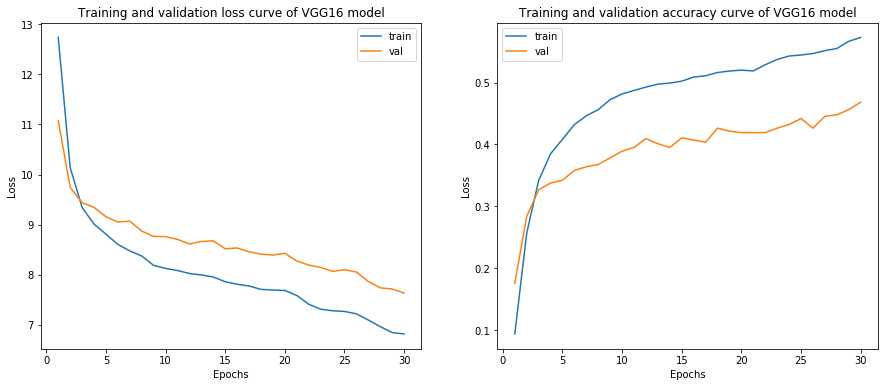

In [28]:
plot_loss_accuracy(vgg16_history, 'VGG16', epochs = 30)

- **VGG16 model is overfitting** on the training data. The training loss is much lower than the validation loss and similarly **training accuracy is much higher than the validation accuracy**. 

### Load the Model with the Best Validation Loss

In [29]:
VGG16_model.load_weights('saved_models/weights.best.VGG16_model.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [30]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis = 0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(VGG16_predictions) == np.argmax(test_targets, axis = 1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.2153%


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- **Transfer Learning** saves a lot of computation and provides really **good performance** specially when dataset is small. I used five different **pre-trained imagenet** model architectures to classify dog breeds. These models include VGG16, VGG19, ResNet50, InceptionV3 and Xception. 
- I removed the classification head from the models and **added a GlobalAveragePooling2D layer followed by a Dense classification layer with softmax activation**. I also freezed the pre-trained weights of the model because these weights are trained and optimized on a very large ImageNet dataset and I do not want to degrade them by training on a small dataset. These pre-trained weights will act as **feature extractors** for the classification model. 
- The GlobalAveragePooling layer helped in **reducing the number of parameters** in the model. I tried using Flatten layer instead of the GlobalAveragePooling layer in the model but the **performance is better with GlobalAveragePooing** layer with less number of parameters.

In [31]:
def load_pretrained_model(model_name, shape = (224, 224, 3), classes = 133):
    """
    This function will load the pre-trained model specified by the model_nam
    
    The pre-trained model will be loaded with imagenet weights and will not 
    have classification head. A GlobalAveragePooling layer followed by a dense
    classification layer will be attached to the pre-trained. Using keras 
    functional API final model will be constructed.
    
    Args:
        model_name: name of the pre-trained model to load, model name could be
                    any one among VGG16, VGG19, ResNet50, InceptionV3, Xception
        shape: input shape to the model (default shape: (224, 224, 3))
        classes: number of output classes (default value: 133)
    
    Returns:
        model: model build using keras functional API
    """
    
    # Check the model name and load the pre-trained model accordingly
    if model_name == 'VGG16':
        base_model = keras.applications.VGG16(include_top = False,
                                              weights = 'imagenet',
                                              input_shape = shape)
        
    elif model_name == 'VGG19':
        base_model = keras.applications.VGG19(include_top = False,
                                              weights = 'imagenet',
                                              input_shape = shape)
        
    elif model_name == 'ResNet50':
        base_model = keras.applications.ResNet50(include_top = False,
                                                 weights = 'imagenet',
                                                 input_shape = shape)
        
    elif model_name == 'InceptionV3':
        base_model = keras.applications.InceptionV3(include_top = False,
                                                    weights = 'imagenet',
                                                    input_shape = shape)
        
    elif model_name == 'Xception':
        base_model = keras.applications.Xception(include_top = False,
                                                 weights = 'imagenet',
                                                 input_shape = shape)
        
    # freeze the base_model weights  
    for layer in base_model.layers:
        layer.trainable = False
        
    # add a global average pooling layer
    x = layers.GlobalAveragePooling2D(name = 'gpool')(base_model.output)
    # add a classification layer
    x = layers.Dense(classes, activation = 'softmax', name = 'output')(x)
    
    # build the model
    model = Model(base_model.inputs, x, name = model_name)
    return model

### (IMPLEMENTATION) Compile and Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [32]:
def compile_fit_model(model, model_name, epochs = 10, batch_size = 32):
    """
    This function will compile and fit the model along with the model checkpoints
    
    Args:
        model: keras model to be trained
        model_name: name of the model to create model checkpoints (string)
        epochs: number of epochs to train the model (default value: 10)
        batch_size: batch size passed to the model during training (default value: 32)
        
    Returns:
        history: model training history
    """
    
    # create model checkpoint based on the name of the model
    if model_name == 'VGG16':
        checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.{model_name}.hdf5', 
                                       verbose = 1, save_best_only = True)
    
    elif model_name == 'VGG19':
        checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.{model_name}.hdf5', 
                                       verbose = 1, save_best_only = True)
        
    elif model_name == 'InceptionV3':
        checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.{model_name}.hdf5', 
                                       verbose = 1, save_best_only = True)
        
    elif model_name == 'ResNet50':
        checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.{model_name}.hdf5', 
                                       verbose = 1, save_best_only = True)
        
    elif model_name == 'Xception':
        checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.{model_name}.hdf5', 
                                       verbose = 1, save_best_only = True)
        
    # compile the model
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'rmsprop', 
                  metrics = ['accuracy'])
    
    # fit the model on the training data
    history = model.fit(train_tensors, train_targets, 
                        epochs = epochs, batch_size = batch_size,
                        callbacks = [checkpointer],
                        validation_data = (valid_tensors, valid_targets),
                        verbose = 1)
    
    return history

## Load and print the summary of VGG19 model

In [33]:
# load VGG19 model
VGG19 = load_pretrained_model('VGG19')

# print the summary of the model
VGG19.summary()

80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

## Fine-tune VGG19 model

In [57]:
# compile and fit the model
vgg19_history = compile_fit_model(VGG19, 'VGG19', epochs = 30)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 141s 21ms/step - loss: 4.8276 - acc: 0.0293 - val_loss: 4.6825 - val_acc: 0.0563
Epoch 2/30
6680/6680 [==============================] - 143s 21ms/step - loss: 4.5458 - acc: 0.0804 - val_loss: 4.4863 - val_acc: 0.0922
Epoch 3/30
6680/6680 [==============================] - 142s 21ms/step - loss: 4.3301 - acc: 0.1253 - val_loss: 4.3207 - val_acc: 0.1186
Epoch 4/30
6680/6680 [==============================] - 143s 21ms/step - loss: 4.1409 - acc: 0.1591 - val_loss: 4.1690 - val_acc: 0.1533
Epoch 5/30
6680/6680 [==============================] - 142s 21ms/step - loss: 3.9771 - acc: 0.1961 - val_loss: 4.0555 - val_acc: 0.1581
Epoch 6/30
6680/6680 [==============================] - 143s 21ms/step - loss: 3.8289 - acc: 0.2277 - val_loss: 3.9584 - val_acc: 0.1569
Epoch 7/30
6680/6680 [==============================] - 142s 21ms/step - loss: 3.7037 - acc: 0.2484 - val_loss: 3.8619 - val_acc: 0

Epoch 26/30
6680/6680 [==============================] - 141s 21ms/step - loss: 2.4604 - acc: 0.4883 - val_loss: 3.0584 - val_acc: 0.2862
Epoch 27/30
6680/6680 [==============================] - 141s 21ms/step - loss: 2.4194 - acc: 0.4901 - val_loss: 3.0473 - val_acc: 0.2850
Epoch 28/30
6680/6680 [==============================] - 141s 21ms/step - loss: 2.3876 - acc: 0.4955 - val_loss: 3.0237 - val_acc: 0.3126
Epoch 29/30
6680/6680 [==============================] - 141s 21ms/step - loss: 2.3531 - acc: 0.5078 - val_loss: 3.0005 - val_acc: 0.2910
Epoch 30/30
6680/6680 [==============================] - 141s 21ms/step - loss: 2.3232 - acc: 0.5099 - val_loss: 2.9858 - val_acc: 0.3102


### Plot the loss and validation curves of VGG19 model

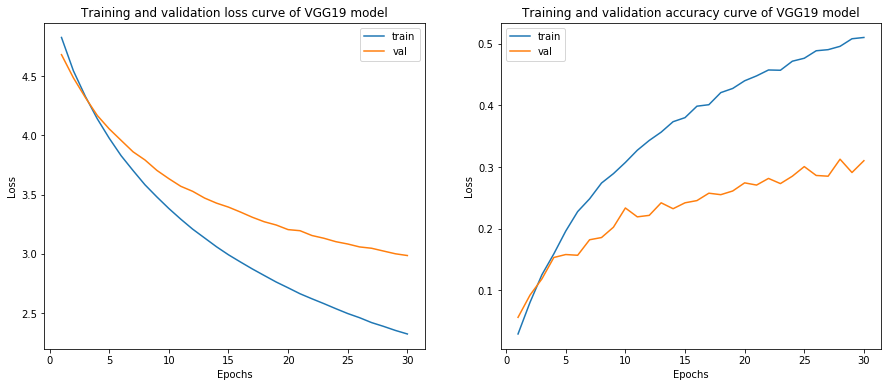

In [58]:
plot_loss_accuracy(vgg19_history, 'VGG19', epochs = 30)

- **VGG19 model is overfitting** on the training data. The training loss is much lower than the validation loss and similarly **training accuracy is much higher than the validation accuracy**. 
- The training accuracy is increasing with every training epoch while the **validation accuracy is nearly about to saturate**.

## Load and print the summary of InceptionV3

In [59]:
# load InceptionV3 model
InceptionV3 = load_pretrained_model('InceptionV3')

# print the summary of the model
InceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________

## Fine-tune InceptionV3 model

In [60]:
# compile and fit the model
inception_history = compile_fit_model(InceptionV3, 'InceptionV3', epochs = 10)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 64s 10ms/step - loss: 2.7195 - acc: 0.4109 - val_loss: 1.3196 - val_acc: 0.6479
Epoch 2/10
6680/6680 [==============================] - 58s 9ms/step - loss: 1.3005 - acc: 0.6648 - val_loss: 1.3783 - val_acc: 0.6263
Epoch 3/10
6680/6680 [==============================] - 58s 9ms/step - loss: 0.9730 - acc: 0.7361 - val_loss: 1.3508 - val_acc: 0.6419
Epoch 4/10
6680/6680 [==============================] - 58s 9ms/step - loss: 0.7878 - acc: 0.7793 - val_loss: 1.3784 - val_acc: 0.6431
Epoch 5/10
6680/6680 [==============================] - 58s 9ms/step - loss: 0.6633 - acc: 0.8135 - val_loss: 1.3817 - val_acc: 0.6407
Epoch 6/10
6680/6680 [==============================] - 58s 9ms/step - loss: 0.5616 - acc: 0.8350 - val_loss: 1.4039 - val_acc: 0.6467
Epoch 7/10
6680/6680 [==============================] - 58s 9ms/step - loss: 0.5063 - acc: 0.8530 - val_loss: 1.3724 - val_acc: 0.6575
Epoch 8

### Plot the loss and validation curves of InceptionV3 model

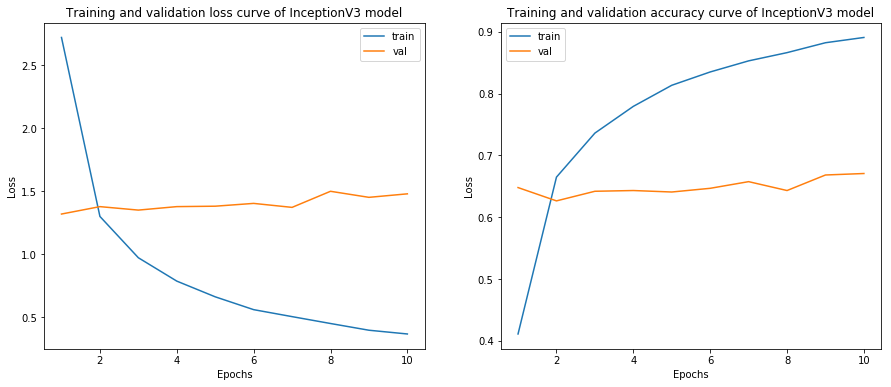

In [61]:
plot_loss_accuracy(inception_history, 'InceptionV3', epochs = 10)

- **InceptionV3 model is overfitting** on the training data. The training accuracy is increasing with every training epoch while the **validation accuracy saturated around 64%**.
- **InceptionV3 performed better than VGG16 and VGG19** on both training and validation sets.

## Load and print the summary of ResNet50 model

In [62]:
# load ResNet50 model
ResNet50 = load_pretrained_model('ResNet50')

# print the summary of the model
ResNet50.summary()

94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 112, 112, 64) 0           bn_conv1[0][0]                   
____________________________________________

## Fine-tune ResNet50 model

In [63]:
# compile and fit the model
resnet_history = compile_fit_model(ResNet50, 'ResNet50', epochs = 10)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 78s 12ms/step - loss: 2.5565 - acc: 0.3991 - val_loss: 6.5944 - val_acc: 0.0072
Epoch 2/10
6680/6680 [==============================] - 72s 11ms/step - loss: 0.8889 - acc: 0.7554 - val_loss: 11.1172 - val_acc: 0.0096
Epoch 3/10
6680/6680 [==============================] - 72s 11ms/step - loss: 0.5365 - acc: 0.8461 - val_loss: 7.3963 - val_acc: 0.0455
Epoch 4/10
6680/6680 [==============================] - 73s 11ms/step - loss: 0.3537 - acc: 0.9000 - val_loss: 3.6121 - val_acc: 0.2766
Epoch 5/10
6680/6680 [==============================] - 73s 11ms/step - loss: 0.2608 - acc: 0.9256 - val_loss: 1.4944 - val_acc: 0.6144
Epoch 6/10
6680/6680 [==============================] - 73s 11ms/step - loss: 0.1878 - acc: 0.9499 - val_loss: 1.2013 - val_acc: 0.6647
Epoch 7/10
6680/6680 [==============================] - 73s 11ms/step - loss: 0.1412 - acc: 0.9611 - val_loss: 1.1415 - val_acc: 0.7018


### Plot the loss and validation curves of ResNet50 model

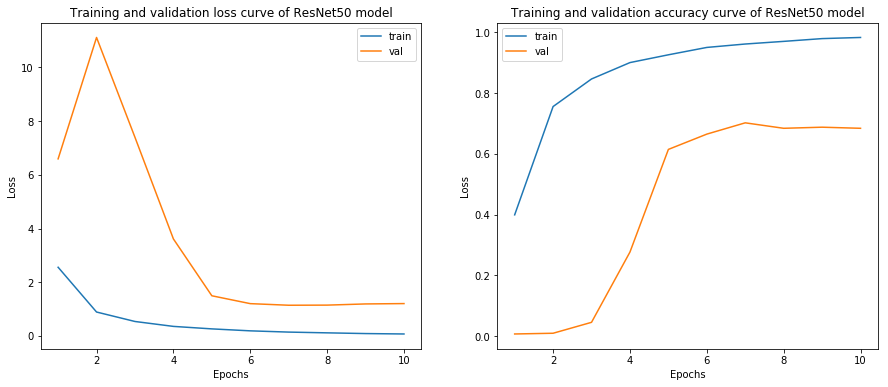

In [64]:
plot_loss_accuracy(resnet_history, 'ResNet50', epochs = 10)

- **ResNet50 model is also overfitting** on the training data. The training accuracy reached above 98% while the **validation accuracy saturated around 68%**.
- **But ResNet50 performed better than VGG16, VGG19 and InceptionV3** on validation data.

## Load and print the summary of Xception model

In [66]:
# load Xception model
Xception = load_pretrained_model('Xception')

# print the summary of the model
Xception.summary()

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________

## Fine-tune Xception model

In [67]:
# compile and fit the model
xception_history = compile_fit_model(Xception, 'Xception', epochs = 10)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 87s 13ms/step - loss: 2.2777 - acc: 0.5723 - val_loss: 0.7885 - val_acc: 0.7665
Epoch 2/10
6680/6680 [==============================] - 82s 12ms/step - loss: 0.8577 - acc: 0.8010 - val_loss: 0.7999 - val_acc: 0.7629
Epoch 3/10
6680/6680 [==============================] - 82s 12ms/step - loss: 0.6147 - acc: 0.8430 - val_loss: 0.7870 - val_acc: 0.7868
Epoch 4/10
6680/6680 [==============================] - 82s 12ms/step - loss: 0.4974 - acc: 0.8680 - val_loss: 0.7492 - val_acc: 0.7880
Epoch 5/10
6680/6680 [==============================] - 82s 12ms/step - loss: 0.4304 - acc: 0.8837 - val_loss: 0.7462 - val_acc: 0.7928
Epoch 6/10
6680/6680 [==============================] - 82s 12ms/step - loss: 0.3712 - acc: 0.8967 - val_loss: 0.7523 - val_acc: 0.7808
Epoch 7/10
6680/6680 [==============================] - 82s 12ms/step - loss: 0.3258 - acc: 0.9100 - val_loss: 0.7382 - val_acc: 0.8000
E

### Plot the loss and validation curves of Xception model

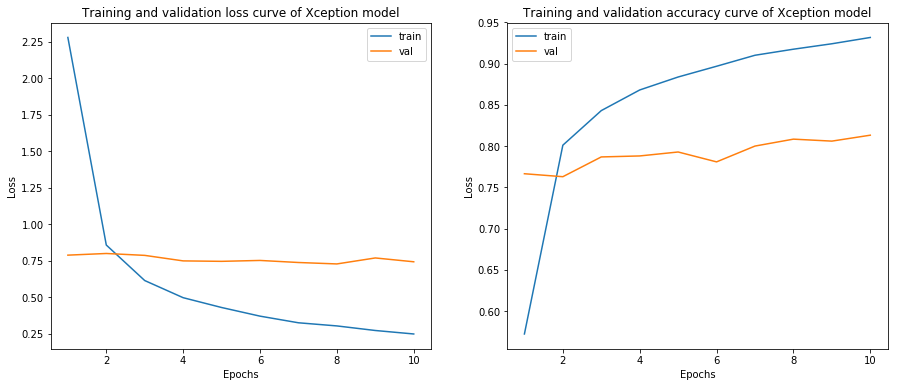

In [69]:
plot_loss_accuracy(xception_history, 'Xception', epochs = 10)

- In comparison with all the models **Xception model performed the best**. The validation accuracy of this model is the highest among all the models trained. Also the **validation loss is lowest** when compared with other models.
- **Xception model** also did overfit on the training data. The training accuracy is around **10% higher than the validation accuracy**. The training loss keeps on decreasing with every epoch while the validation loss didn't decrease much.
- **In order to avoid overfitting, I need to train this model with data augmentation**.

## Create data augmentation to avoid overfitting

In [68]:
def augment_data(batch_size = 32):
    """
    This function will generate augmented data to train the models
    
    Args:
        batch_size: batch size of the data (default value: 32)
        
    Returns:
        train_gen: data augmentation object for training data
        val_gen: data augmentation object for validation data
    """
    
    # instantiate train data augmentation object
    train_aug = image.ImageDataGenerator(horizontal_flip = True,
                                         rotation_range = 30,
                                         height_shift_range = 0.2,
                                         width_shift_range = 0.2,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         fill_mode = 'nearest')
    
    # create train data generator
    train_gen = train_aug.flow(train_tensors, train_targets, batch_size = batch_size)
    
    # no augmentation on validation data
    val_aug = image.ImageDataGenerator()
    # create validation data generator
    val_gen = val_aug.flow(valid_tensors, valid_targets, batch_size = batch_size)
    
    return train_gen, val_gen

In [70]:
# get training and validation generators
train_gen, val_gen = augment_data()

## Display few random images to show data augmentation

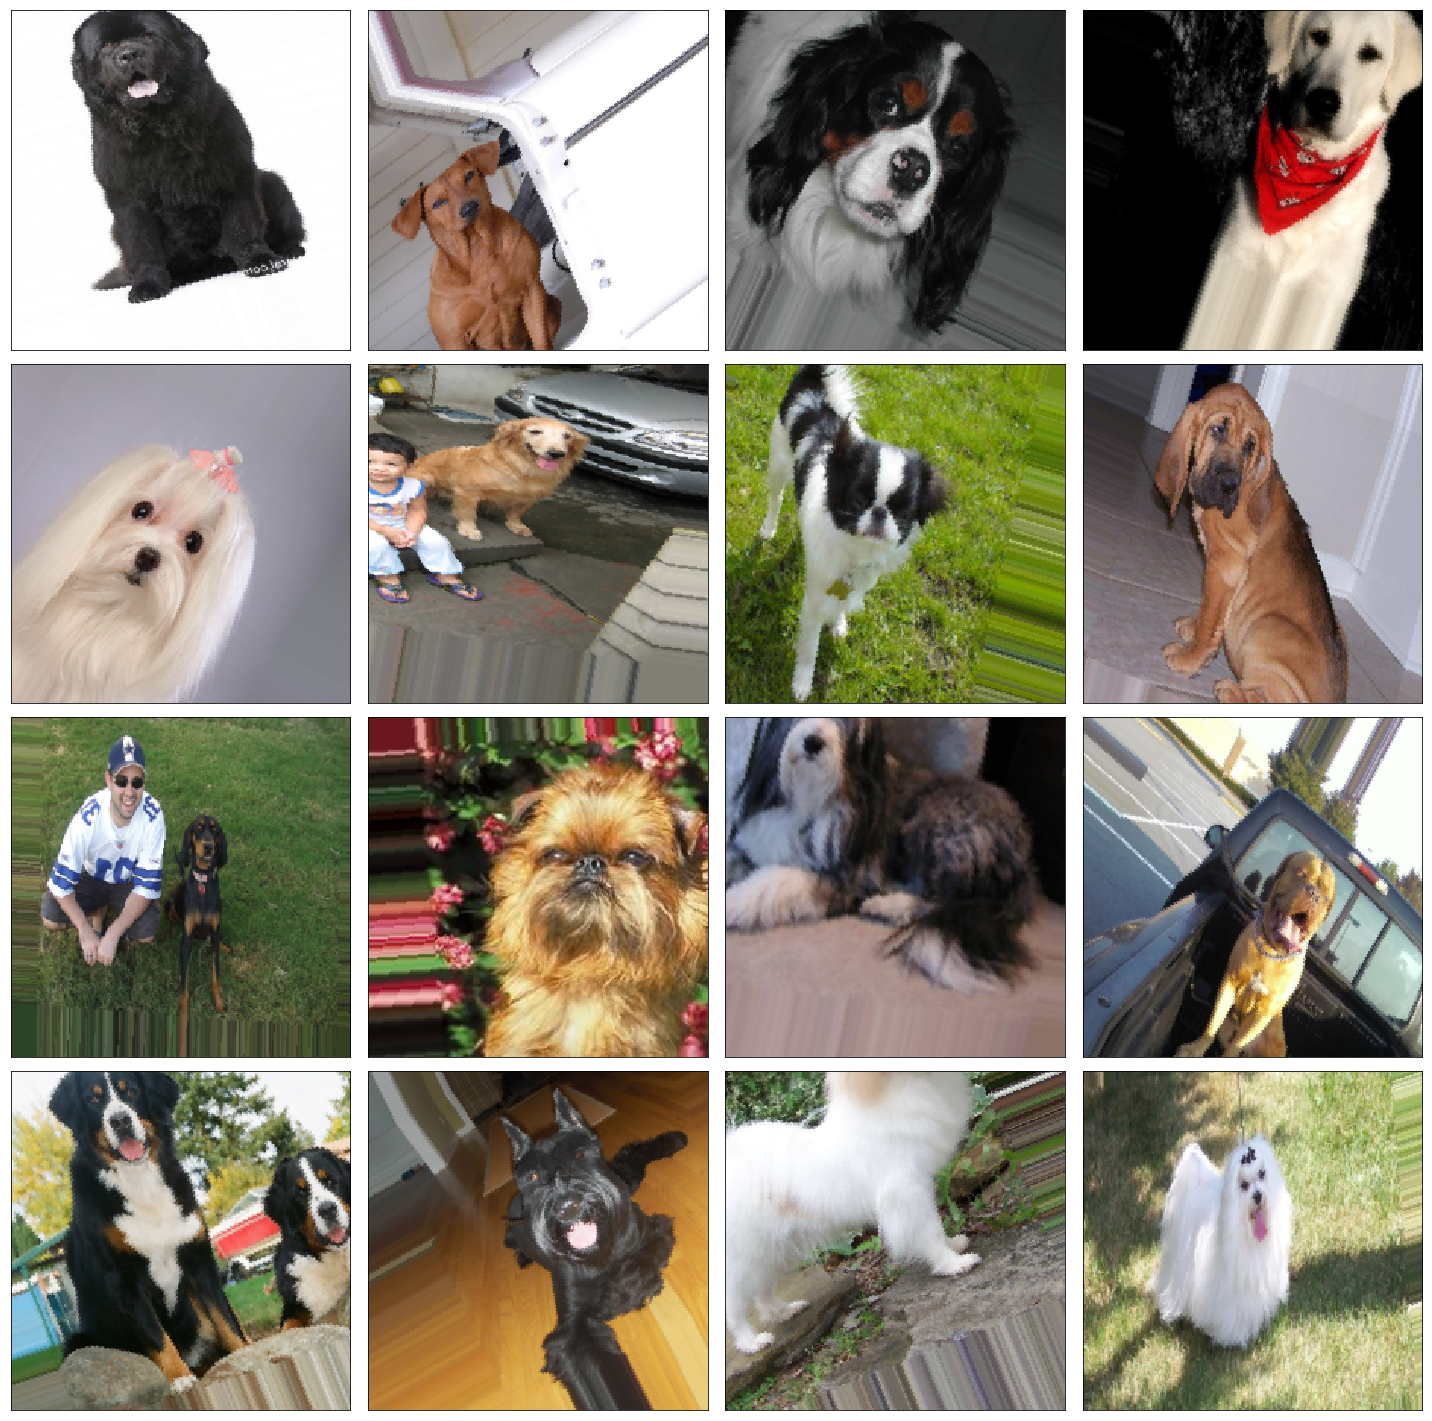

In [71]:
batch_imgs, batch_labels = next(iter(train_gen))

# create figure object
fig, axes = plt.subplots(4, 4, figsize = (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(batch_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

## Train Xception model with data augmentation

In [72]:
# compile the model
Xception.compile(loss = 'categorical_crossentropy', 
                 optimizer = 'rmsprop', 
                 metrics = ['accuracy'])

# create model check points
checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.Xception_data_aug.hdf5', 
                                       verbose = 1, save_best_only = True)

# fit the model on the training data
Xception.fit_generator(train_gen, 
                       epochs = 5, 
                       steps_per_epoch = len(train_tensors) // 32,
                       callbacks = [checkpointer],
                       validation_data = val_gen,
                       validation_steps = len(valid_tensors) // 32,
                       verbose = 1)

Epoch 1/5
208/208 [==============================] - 82s 394ms/step - loss: 0.9068 - acc: 0.7530 - val_loss: 0.6576 - val_acc: 0.8089
Epoch 2/5
208/208 [==============================] - 81s 387ms/step - loss: 0.8352 - acc: 0.7725 - val_loss: 0.6572 - val_acc: 0.8089
Epoch 3/5
208/208 [==============================] - 80s 385ms/step - loss: 0.8523 - acc: 0.7590 - val_loss: 0.6593 - val_acc: 0.8137
Epoch 4/5
208/208 [==============================] - 81s 389ms/step - loss: 0.8095 - acc: 0.7754 - val_loss: 0.6339 - val_acc: 0.8101
Epoch 5/5
208/208 [==============================] - 81s 388ms/step - loss: 0.7947 - acc: 0.7860 - val_loss: 0.6413 - val_acc: 0.8161


### Plot the loss and validation curves of Xception model with data augmentation

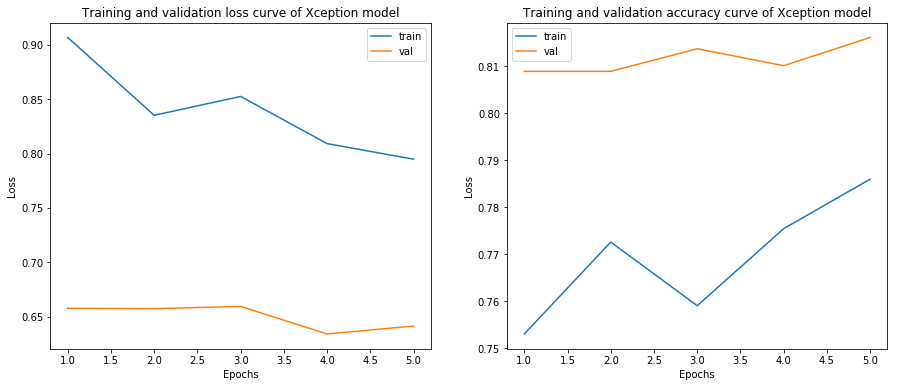

In [73]:
plot_loss_accuracy(Xception.history, 'Xception', epochs = 5)

- As can be seen from the above graphs, **the model is not overfitting on the training data when trained with data augmentation**. The validation accuracy is higher than the training accuracy and the **validation loss is lower than the training loss**.
- To improve the performance of the model further, I **trained the last two blocks of the Xception model by unfreezing the weights of these blocks**.

### Fine-tune the last two blocks of Xception model

In [75]:
# print the layer information of the Xception model
for i, layer in enumerate(Xception.layers):
    print(f'Layer number: {i}\tLayer name: {layer.name}')

Layer number: 0	Layer name: input_7
Layer number: 1	Layer name: block1_conv1
Layer number: 2	Layer name: block1_conv1_bn
Layer number: 3	Layer name: block1_conv1_act
Layer number: 4	Layer name: block1_conv2
Layer number: 5	Layer name: block1_conv2_bn
Layer number: 6	Layer name: block1_conv2_act
Layer number: 7	Layer name: block2_sepconv1
Layer number: 8	Layer name: block2_sepconv1_bn
Layer number: 9	Layer name: block2_sepconv2_act
Layer number: 10	Layer name: block2_sepconv2
Layer number: 11	Layer name: block2_sepconv2_bn
Layer number: 12	Layer name: conv2d_95
Layer number: 13	Layer name: block2_pool
Layer number: 14	Layer name: batch_normalization_95
Layer number: 15	Layer name: add_33
Layer number: 16	Layer name: block3_sepconv1_act
Layer number: 17	Layer name: block3_sepconv1
Layer number: 18	Layer name: block3_sepconv1_bn
Layer number: 19	Layer name: block3_sepconv2_act
Layer number: 20	Layer name: block3_sepconv2
Layer number: 21	Layer name: block3_sepconv2_bn
Layer number: 22	Lay

In [76]:
# make the last two blocks of Xception model trainable
for layer in Xception.layers[116:]:
    layer.trainable = True

In [77]:
# compile the model
Xception.compile(loss = 'categorical_crossentropy', 
                 optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9), 
                 metrics = ['accuracy'])

# create model check points
checkpointer = ModelCheckpoint(filepath = f'saved_models/weights.best.Xception_tuned.hdf5', 
                                       verbose = 1, save_best_only = True)

# fit the model on the training data
Xception.fit_generator(train_gen, 
                       epochs = 5, 
                       steps_per_epoch = len(train_tensors) // 32,
                       callbacks = [checkpointer],
                       validation_data = val_gen,
                       validation_steps = len(valid_tensors) // 32,
                       verbose = 1)

Epoch 1/5
208/208 [==============================] - 95s 457ms/step - loss: 0.6801 - acc: 0.8054 - val_loss: 0.5899 - val_acc: 0.8113
Epoch 2/5
208/208 [==============================] - 93s 449ms/step - loss: 0.6158 - acc: 0.8150 - val_loss: 0.5859 - val_acc: 0.8221
Epoch 3/5
208/208 [==============================] - 93s 448ms/step - loss: 0.5596 - acc: 0.8302 - val_loss: 0.5870 - val_acc: 0.8257
Epoch 4/5
208/208 [==============================] - 93s 447ms/step - loss: 0.5167 - acc: 0.8441 - val_loss: 0.5890 - val_acc: 0.8269
Epoch 5/5
208/208 [==============================] - 93s 449ms/step - loss: 0.4926 - acc: 0.8527 - val_loss: 0.5635 - val_acc: 0.8245


- The **validation accuracy increased and the validation loss decreased** after fine-tunig the last two blocks of the Xception model.

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
Xception.load_weights('saved_models/weights.best.Xception_tuned.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [38]:
### TODO: Calculate classification accuracy on the test dataset.
test_acc = Xception.evaluate(test_tensors, test_targets)[1] * 100.0
print(f'Test accuracy: {np.round (test_acc, 4)}%')

836/836 [==============================] - 11s 13ms/step
Test accuracy: 83.4928%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

In [39]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def predict_dog_breed(model, img_path):
    """
    This function will predict the breed on the dog
    
    Args:
        model: keras model to predict the dog breed
        img_path: path of the image (string)
        
    Returns:
        name of the dog breed
    """
    # read the image
    image = cv2.imread(img_path)
    # convert the image from BGR format to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize the image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # add batch dimension to the image
    image = np.expand_dims(image, 0)
    # make prediction on the image
    pred = np.argmax(model.predict(image), axis = -1)[0]
    # return the dog breed
    return dog_names[pred].split('.')[-1]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [46]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def human_dog_resembler(model, img_path):
    """
    This function will detect dog or human in the image
    
    If dog is detected it predicts the breed on the dog, if human is 
    detected it predicts the resembling dog breed and if neither is
    detected it indicates an error.
    
    Args:
        model: model to predict dog breed 
        img_path: path of the image (string)
        
    Returns:
        dog_breed: name of the dog breed
    """
    # check if dog is detected in the image
    if dog_detector(img_path):
        dog_breed = predict_dog_breed(model, img_path)
        print(f'Dog breed: {dog_breed}')
        return dog_breed
    
    # check if human is detected in the image
    elif face_detector(img_path):
        dog_breed = predict_dog_breed(model, img_path)
        print(f'This person resembles {dog_breed} dog breed most')
        return dog_breed
    
    else:
        return print(f'Please provide dog or human images')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
- The output is not as good as I expected. This is because the number of classes in the dataset is very large and the number of images per class is small. The **accuracy of the final model on the test dataset is 83.5%**. This is not a good classification accuracy. Deep learning models are **capable of achieving accuracies > 95%** very easily when provided with enough data. 
- In order to improve the performance of the dog breed prediction model we can do the following things:
    1. Get more number of images per class
    2. Make the dataset balanced
    3. Use image augmentation methods such as **CutOut, MixUp and CutMix** 
    4. Use **VAEs/GANs to generate artificial data**
    5. Use more **efficient algorithms such as EfficientNet**
    6. Use activation maps to interpret the model

Dog breed: German_shepherd_dog


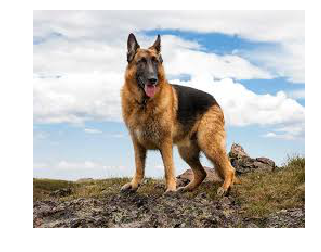

In [41]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.

img = cv2.imread('german_shepherd.jpg')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'german_shepherd.jpg')
plt.imshow(img)
plt.axis('off');

This person resembles Belgian_tervuren dog breed most


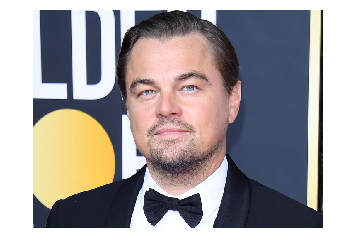

In [44]:
img = cv2.imread('human.png')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'human.png')
plt.imshow(img)
plt.axis('off');

Please provide dog or human images


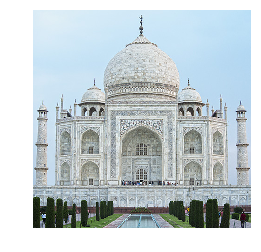

In [47]:
img = cv2.imread('taj.jpg')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'taj.jpg')
plt.imshow(img)
plt.axis('off');

This person resembles German_shepherd_dog dog breed most


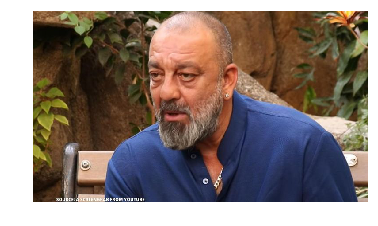

In [49]:
img = cv2.imread('sanjay.jpeg')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'sanjay.jpeg')
plt.imshow(img)
plt.axis('off');

Please provide dog or human images


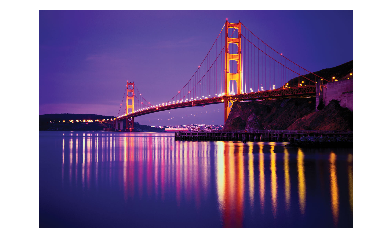

In [50]:
img = cv2.imread('Golden-Gate-Bridge-San-Francisco.jpg')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'Golden-Gate-Bridge-San-Francisco.jpg')
plt.imshow(img)
plt.axis('off');

Dog breed: German_shepherd_dog


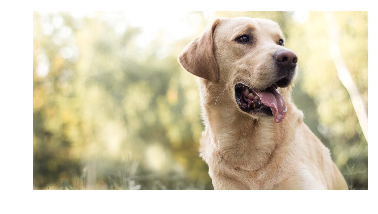

In [51]:
img = cv2.imread('labrador-retriever.jpg')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'labrador-retriever.jpg')
plt.imshow(img)
plt.axis('off');

Please provide dog or human images


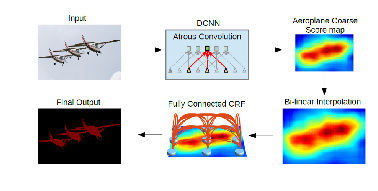

In [52]:
img = cv2.imread('Deep Lab.png')
# convert the image from BGR format to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# call the function to get the dog breed
breed = human_dog_resembler(Xception, 'Deep Lab.png')
plt.imshow(img)
plt.axis('off');